In [42]:
from glob import glob
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_array
from functools import reduce

import config
import sys
sys.path.append("../")

from sklearn.metrics import ndcg_score
from detect import detect_singlebatch, detect_multibatch, _get_altered_in_window
from utils import get_support_bucket

In [225]:
dataset = "celeba" # or "celeba"
metric = "accuracy" # metric that will be studied
support_range = (0.01, 0.05) # define a range of values for the support

if dataset == "adult":
    noise = 0.5
    ckpt_dir = "/data2/fgiobergia/drift-experiments/"
    checkpoint = "xgb-adult"
elif dataset == "celeba":
    noise = 1.0
    ckpt_dir = os.path.join(config.ckpt_dir, "sup-wise")
    checkpoint = "resnet50"

fnames = glob(os.path.join(ckpt_dir, f"{checkpoint}-noise-{noise:.2f}*pkl"))
supports = [ get_support_bucket(fname) for fname in fnames ]

df_names = pd.DataFrame({ "filename": fnames, "from_sup": [a for a,b in supports], "to_sup": [b for a,b in supports] })

In [237]:
matches_filename = os.path.join(config.ckpt_dir, f"matches-{checkpoint}.pkl")

# from_sup, to_sup = support_range
# mask = ((df_names["from_sup"] > from_sup) & (df_names["to_sup"] < to_sup))
# if mask.sum() == 0:
#     print("No files found with the specified support range")
# else:
#     tgt = df_names[mask].sample(1).iloc[0].filename

# Some good files 👇
tgt = '../../models-ckpt/sup-wise/resnet50-noise-1.00-support-0.0207-0.0264-target-38-7-18-20-23-24-30.pkl'

with open(tgt, "rb") as f:
    obj = pickle.load(f)
    sg = frozenset(obj["subgroup"])
    accuracies = obj["accuracies"]
    f1 = obj["f1"]
    divs = obj["divs"]
    y_trues = obj["y_trues"]
    y_preds = obj["y_preds"]
    # noise_fracs = obj["noise_fracs"]
    altered = obj["altered"]
    matches_ts_list = obj["matches_batches"]

with open(matches_filename, "rb") as f:
    matches_obj = pickle.load(f)
    df_train = matches_obj["metadata_train"]
    # df_tests = matches_obj["metadata_batches"]
    # matches = matches_obj["matches_train"]
    # matches_ts_list = matches_obj["matches_batches"]

for div in divs:
    div.set_index("subgroup", inplace=True)
    div["accuracy"] = (div["tp"] + div["tn"]) / (div["tp"] + div["tn"] + div["fp"] + div["fn"])
    div["f1"] = 2 * div["tp"] / (2 * div["tp"] + div["fp"] + div["fn"])

ndx = divs[0].index
ndx_target = (ndx == sg).nonzero()[0][0]

In [238]:
print("Subgroup", list(sg))
print("Itemset", df_train.columns[list(sg)].tolist())
print("Support", matches.matches[:, [ndx_target]].mean())

Subgroup [38, 7, 18, 20, 23, 24, 30]
Itemset ['Young', 'Black_Hair', 'High_Cheekbones', 'Mouth_Slightly_Open', 'No_Beard', 'Oval_Face', 'Smiling']
Support 0.02396841066140178


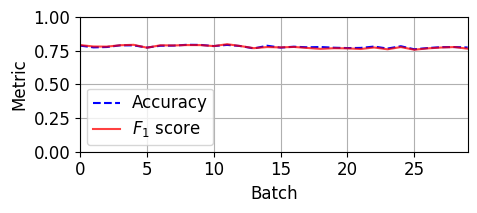

In [239]:
fig, ax = plt.subplots(figsize=(5, 1.75))

ax.plot(accuracies, label="Accuracy", color='b', ls='--')
ax.plot(f1, label="$F_1$ score", color='r', alpha=.75)
ax.set_xlabel("Batch")
ax.set_ylabel("Metric")
ax.legend()
ax.grid()

ax.set_ylim([0., 1.0])
ax.set_xlim([0, 29])

# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(12)

fig.savefig("f1-acc-overall.pdf", bbox_inches='tight')

In [240]:
window = 5
# delay = 0
# start_noise = window
# equal_var = False

scores = np.vstack([ d[metric].values for d in divs ]).T

In [241]:
altered_per_sg = np.vstack([ matches_ts_list[i].matches[altered[i]].sum(axis=0) for i in range(len(matches_ts_list)) ])
count_per_sg =   np.vstack([ matches_ts_list[i].matches.sum(axis=0) for i in range(len(matches_ts_list)) ])
count_per_sg[count_per_sg == 0] = 1 # avoid division by 0 (fraction will still be 0)
altered_frac = altered_per_sg / count_per_sg

altered_in_win = _get_altered_in_window(matches_ts_list, altered_frac, (len(divs)-window, window)) # how many were altered in the last window? (fraction, for each subgroup)
altered_in_win[np.isnan(altered_in_win)] = 0

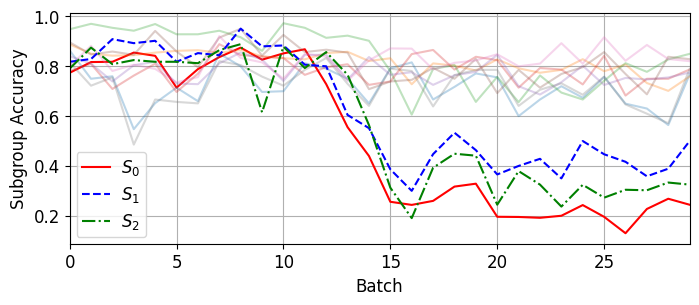

In [244]:
fig, ax = plt.subplots(figsize=(8, 3))
np.random.seed(5)

M = 8
N = 2
threshold = 0.4 # plot N subgroups with altered_in_win > threshold and M < threshold
colors = "bgk"
style = ['--', '-.', ':']
assert len(colors) >= N and len(style) >= N

random_M = np.random.choice((altered_in_win < threshold).nonzero()[0], M, replace=False)
random_N = np.random.choice((altered_in_win > threshold).nonzero()[0], N, replace=False)

ax.plot(scores[ndx_target], color='r', label="$S_0$")

for i in random_M:
    ax.plot(scores[i], alpha=.3)

for pos, (i, c, ls) in enumerate(zip(random_N, colors, style)):
    ax.plot(scores[i], label=f"$S_{{{pos+1}}}$", color=c, ls=ls)


ax.set_xlabel("Batch")
ax.set_ylabel(f"Subgroup Accuracy")
ax.grid()
ax.set_axisbelow(True)
ax.legend()
# increase font size
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
    item.set_fontsize(12)
ax.set_xlim([0, 29])
fig.savefig("drift-example.pdf", bbox_inches="tight")

In [245]:
delta, t_stat = detect_singlebatch(divs, metric, (0, window), (len(divs)-window, len(divs)))
delta_values = delta.values
delta_values[np.isnan(delta_values)] = 0

tstat_values = t_stat.values
tstat_values[np.isnan(tstat_values)] = 0

ndcg_score(altered_in_win.reshape(1,-1), -delta_values.reshape(1,-1)), ndcg_score(altered_in_win.reshape(1,-1), tstat_values.reshape(1,-1))

(0.9888981142890849, 0.9756144069805155)

In [246]:
print("Deltas", delta_values)
print("T-stats", tstat_values)

Deltas [-0.01782248  0.00511999 -0.00520563 ...  0.0097731   0.01632454
  0.01632454]
T-stats [3.58369403 0.74690861 0.52324591 ... 0.33905679 0.53704122 0.53704122]


Correlation -0.8984425928225092
Correlation 0.8281900362640362


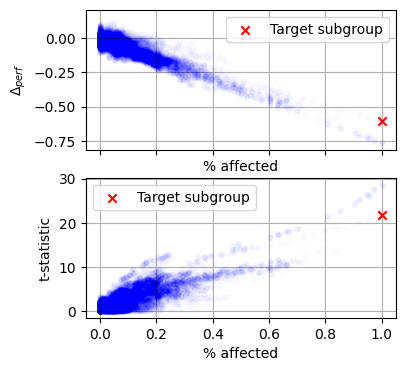

In [248]:
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)

alpha = .01
ax[0].scatter(altered_in_win, delta_values, alpha=alpha, s=10, c='b')
ax[0].scatter([altered_in_win[ndx_target]], [delta[ndx_target]], marker='x', c='r', label="Target subgroup")

ax[0].set_xlabel(r"% affected")
ax[0].set_ylabel(r"$\Delta_{perf}$")
ax[0].grid()
ax[0].set_axisbelow(True)
ax[0].legend()
print("Correlation", np.corrcoef(altered_in_win, delta_values)[0,1])

ax[1].scatter(altered_in_win, tstat_values, alpha=alpha, s=10, c='b')
ax[1].scatter([altered_in_win[ndx_target]], [t_stat[ndx_target]], marker='x', c='r', label="Target subgroup")

ax[1].set_xlabel(r"% affected")
ax[1].set_ylabel(r"t-statistic")
ax[1].grid()
ax[1].legend()
ax[1].set_axisbelow(True)

# increase font sizes
for i in range(2):
    for item in ([ax[i].title, ax[i].xaxis.label, ax[i].yaxis.label] +
                ax[i].get_xticklabels() + ax[i].get_yticklabels() + ax[i].legend().get_texts()):
        item.set_fontsize(10)

print("Correlation", np.corrcoef(altered_in_win, tstat_values)[0,1])

fig.savefig("correlation.pdf", bbox_inches="tight")